<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/corncomp_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Notes and TODO:
- Flip rotate/flip images so view column is same for each pciture
- Proper labels for each photo
- Background color


In [4]:
!pip install kaggle fastkaggle fastai timm>=0.6.2.dev0

In [2]:
from google.colab import files
import pandas as pd
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle #creating folder
! cp kaggle.json ~/.kaggle/ #copying kaggle.json
! chmod 600 ~/.kaggle/kaggle.json #reading the file with full access

In [5]:
from fastkaggle import * 

comp = 'kaggle-pog-series-s01e03'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 491M/491M [00:04<00:00, 114MB/s]


In [26]:
path = Path('/content/kaggle-pog-series-s01e03/corn/')
path

Path('/content/kaggle-pog-series-s01e03/corn')

In [7]:
from fastai.vision.all import *

path.ls()

(#1) [Path('kaggle-pog-series-s01e03/corn')]

In [27]:
trn_path = path/'train'
files = get_image_files(trn_path)
files

(#14322) [Path('/content/kaggle-pog-series-s01e03/corn/train/04056.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/11320.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/05914.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/00171.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/17000.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/05832.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/00391.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/13444.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/00228.png'),Path('/content/kaggle-pog-series-s01e03/corn/train/17281.png')...]

In [28]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,seed_id,view,image,label
0,0,top,train/00000.png,broken
1,1,bottom,train/00001.png,pure
2,3,top,train/00003.png,broken
3,4,top,train/00004.png,pure
4,5,top,train/00005.png,discolored


In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14322 entries, 0 to 14321
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   seed_id  14322 non-null  int64 
 1   view     14322 non-null  object
 2   image    14322 non-null  object
 3   label    14322 non-null  object
dtypes: int64(1), object(3)
memory usage: 447.7+ KB


(160, 168)


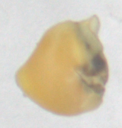

In [29]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

Looks like these images are 160 x 168 -- let's check all their sizes. This is faster if we do it in parallel, so we'll use fastcore's parallel for this.

In [16]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(140, 136)    187
(132, 132)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(168, 162)      1
(129, 132)      1
(139, 160)      1
(113, 148)      1
(204, 136)      1
Length: 784, dtype: int64

Looks like a lot of our images vary in size, lets resize each image to a common dimension size or it will be hard to create batches. 

Since all our images are not seperated in labeled folder we need to create some functions to extract and label our data

This code feels bad probably a more efficent way to do this and this took way more time to do than expected lol.

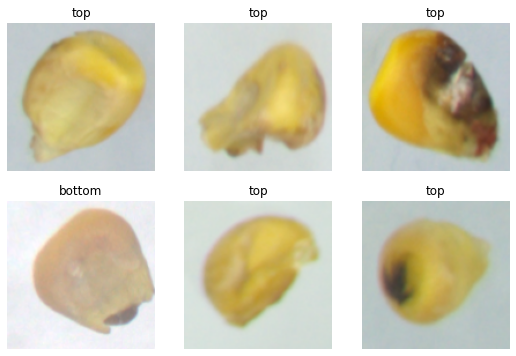

In [156]:
dls2 = ImageDataLoaders.from_csv(path, 'train.csv', fn_col=2, item_tfms=Resize(160, method='squish'),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))
dls2.show_batch(max_n=6)

In [157]:
learn = vision_learner(dls2, 'resnet26d', metrics=error_rate, path='.').to_fp16()

In [159]:
learn.lr_find(suggest_funcs=(valley, slide))

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


KeyboardInterrupt: ignored

In [143]:
learn.fine_tune(3, 0.01)

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.174825,1.072051,0.405377,24:39


epoch,train_loss,valid_loss,error_rate,time
0,0.913048,0.866034,0.336243,31:45
1,0.765837,0.736205,0.298883,31:55
2,0.642836,0.699863,0.286313,32:15


In [144]:
ss = pd.read_csv(path/'sample_submission.csv')
ss

In [145]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)

In [147]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


TensorBase([0, 2, 1,  ..., 2, 2, 2])

In [148]:
dls.vocab

['broken', 'discolored', 'pure', 'silkcut']

In [149]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0           broken
1             pure
2       discolored
3           broken
4           broken
           ...    
3474    discolored
3475    discolored
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

In [150]:
ss['label'] = results
ss.to_csv('submission.csv', index=False)
!head submission.csv

seed_id,label
8632,broken
11394,pure
17362,discolored
9987,broken
17226,broken
17100,pure
968,pure
4069,pure
8505,broken


In [151]:
from kaggle import api
api.competition_submit_cli('submission.csv', 'initial rn26d 128px', comp)

100%|██████████| 40.7k/40.7k [00:00<00:00, 136kB/s]


Successfully submitted to It's Corn (PogChamps #3)